# City Taxi Demand Prediction

**Description**<br>
Cab booking system is the process where renting a cab is automated through an app throughout a city. Using this app, people can book a cab from one location to another location. Being a cab booking app company, exploiting the understanding of cab supply and demand could increase the efficiency of their service and enhance user experience by minimizing waiting time.

**Objective of this project** is to combine historical usage pattern along with the open data sources like weather data to forecast cab booking demand in a city.

## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load the dataset

In [ ]:
# training dataset
train = pd.read_csv('/content/drive/MyDrive/edureka_PGP/mid_project_1/train.csv')
train_label = pd.read_csv('/content/drive/MyDrive/edureka_PGP/mid_project_1/train_label.csv', header=None)

In [ ]:
# Appending target label to the main dataframe
train['Total_booking'] = train_label[0] 

In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184


## Missing value analysis

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       8708 non-null   object 
 1   season         8708 non-null   object 
 2   holiday        8708 non-null   int64  
 3   workingday     8708 non-null   int64  
 4   weather        8708 non-null   object 
 5   temp           8708 non-null   float64
 6   atemp          8708 non-null   float64
 7   humidity       8708 non-null   int64  
 8   windspeed      8708 non-null   float64
 9   Total_booking  8708 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 680.4+ KB


In [ ]:
train.isna().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
dtype: int64

From the information obtained with the above analysis, we confirm that there are no missing values present in the dataset.

## Outlier Analysis

In [ ]:
np.sum(train['workingday'] == train['holiday'])

2536

In [ ]:
(np.sum(train['workingday'] == train['holiday'])/train.shape[0])*100

29.12264584290308

It looks like we have 29.12 % (or 2536) of observations where both holiday and workingday values are same which is not correct and should be considered as missing values.

In [ ]:
train['holiday'].value_counts(normalize=True)*100

0    97.152044
1     2.847956
Name: holiday, dtype: float64

In [ ]:
train['workingday'].value_counts(normalize=True)*100

1    68.029398
0    31.970602
Name: workingday, dtype: float64

From these we can observe that the dataset is more skewed towards holidays compared working days, so it would be better if we replace those entries which are considered to be as outliers with 1 (i.e. workingday)

In [ ]:
train.loc[train['workingday'] == train['holiday'],'holiday'] = 1

In [ ]:
train['holiday'].value_counts(normalize=True)*100

0    68.029398
1    31.970602
Name: holiday, dtype: float64

After this imputation we observe that both the holiday and workingday follows the same distribution i.e. $$ holiday = 1 - workingday $$

In [ ]:
train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,Total_booking
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,0.319706,0.680294,20.243020,23.655552,61.649173,12.843891,193.007005
std,0.466389,0.466389,7.813494,8.501107,19.199578,8.190314,181.552211
min,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,13.940000,16.665000,46.000000,7.001500,43.000000
50%,0.000000,1.000000,20.500000,24.240000,61.000000,12.998000,148.000000
75%,1.000000,1.000000,26.240000,31.060000,77.000000,16.997900,286.000000
max,1.000000,1.000000,41.000000,45.455000,100.000000,56.996900,977.000000


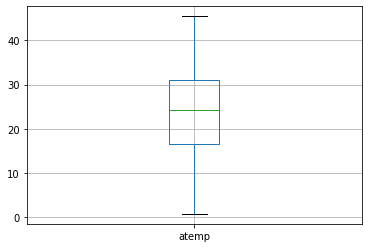

In [ ]:
train.boxplot(['atemp'])
plt.show()

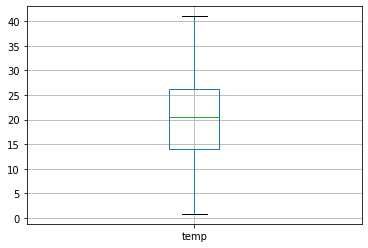

In [ ]:
train.boxplot(['temp'])
plt.show()

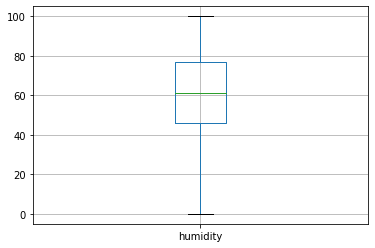

In [ ]:
train.boxplot(['humidity'])
plt.show()

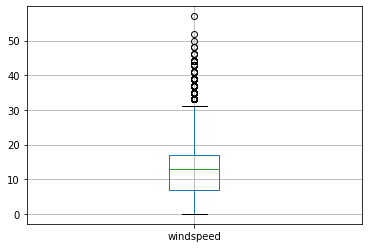

In [ ]:
train.boxplot(['windspeed'])
plt.show()

In [ ]:
q1 = train['windspeed'].quantile(0.25)
q3 = train['windspeed'].quantile(0.75)
iqr = q3 - q1
lower_lim = q1 - 1.5 * iqr
upper_lim = q3 + 1.5 * iqr
windspeed = train['windspeed']
idx = (train['windspeed'] < lower_lim) | (train['windspeed'] > upper_lim)
print(len(windspeed[idx])/train.shape[0])

0.02090032154340836


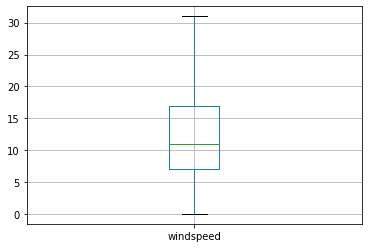

In [ ]:
train = train[~idx.values]
train.boxplot(['windspeed'])
plt.show()

It looks like wind speed feature has around 2% of outliers. So as it is very low, its fine for us to remove those outliers from the dataset for the further analysis. After removing, we observe that this feature has no outliers.

## Feature Engineering

In [ ]:
for cat in ['season', 'weather']:
  train[cat] = train[cat].astype('category')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8526 entries, 0 to 8707
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   datetime       8526 non-null   object  
 1   season         8526 non-null   category
 2   holiday        8526 non-null   int64   
 3   workingday     8526 non-null   int64   
 4   weather        8526 non-null   category
 5   temp           8526 non-null   float64 
 6   atemp          8526 non-null   float64 
 7   humidity       8526 non-null   int64   
 8   windspeed      8526 non-null   float64 
 9   Total_booking  8526 non-null   int64   
dtypes: category(2), float64(3), int64(4), object(1)
memory usage: 616.5+ KB


Now the data looks like in a perfect shape that the categorical columns looks categorical and numerical fields look numerical

In [ ]:
def process_data(df):
  df['datetime'] = pd.to_datetime(df['datetime'])
  df['day'] = df['datetime'].dt.day
  df['month'] = df['datetime'].dt.month
  df['year'] = df['datetime'].dt.year
  df['day_name'] = df['datetime'].dt.day_name()
  df['hour'] = df['datetime'].dt.hour
  df['weekday'] = df['datetime'].dt.weekday
  return df

In [ ]:
_ = process_data(train)

Now that we have extracted useful features from the datetime feature, we can drop this feature from the original dataset

In [ ]:
train.drop('datetime', axis=1, inplace=True)

In [ ]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,day,month,year,day_name,hour,weekday
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2,5,2012,Wednesday,19,2
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,5,9,2012,Wednesday,4,2
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,13,1,2011,Thursday,9,3
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,18,11,2011,Friday,16,4
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,13,9,2011,Tuesday,13,1


As there is a cylic pattern w.r.t. day, month, hour and weekday, we need to take this into consideration

In [ ]:
train['hr_sin'] = np.sin(train['hour']*(2.*np.pi/24))
train['hr_cos'] = np.cos(train['hour']*(2.*np.pi/24))
train['mnth_sin'] = np.sin((train['month']-1)*(2.*np.pi/12))
train['mnth_cos'] = np.cos((train['month']-1)*(2.*np.pi/12))

## Visualizing Total_booking vs other features to generate insights

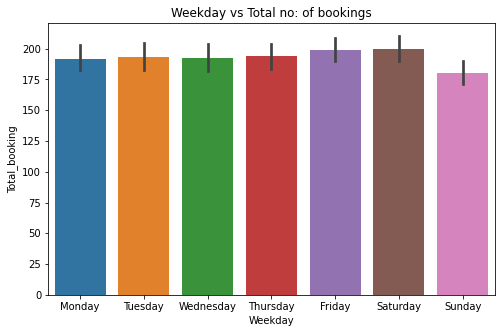

In [ ]:
x = train.sort_values('weekday')['day_name']
y = train['Total_booking']
plt.figure(figsize=(8, 5))
sns.barplot(x = x, y = y)
plt.title('Weekday vs Total no: of bookings')
plt.xlabel('Weekday')
plt.show()

From the above Barplot we observe that the bookings on the weekdays seems to follow nearly a uniform distribution but the bookings are slightly high on the weekends especially on Friday and Saturday.

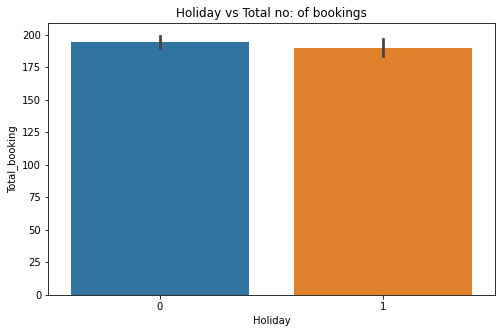

In [ ]:
x = train['holiday']
y = train['Total_booking']
plt.figure(figsize=(8, 5))
sns.barplot(x = x, y = y)
plt.title('Holiday vs Total no: of bookings')
plt.xlabel('Holiday')
plt.show()

The number of bookings on the working days compared to the holidays. This may also imply that due to the imputation of outliers in the holidays with working days.

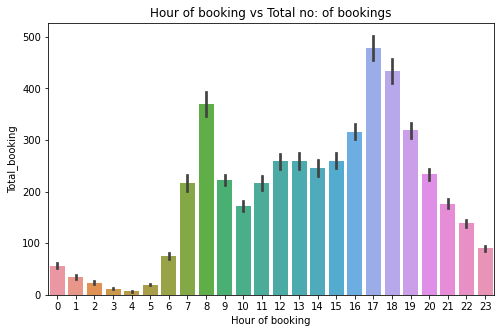

In [ ]:
x = train.sort_values('weekday')['hour']
y = train['Total_booking']
plt.figure(figsize=(8, 5))
sns.barplot(x = x, y = y)
plt.title('Hour of booking vs Total no: of bookings')
plt.xlabel('Hour of booking')
plt.show()

It seems like people tend to travel more at the end of the  office hours using cabs rather than beginning hours

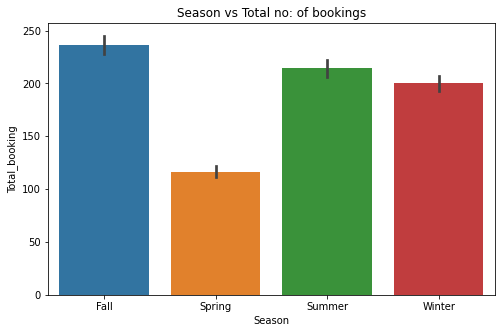

In [ ]:
x = train['season']
y = train['Total_booking']
plt.figure(figsize=(8, 5))
sns.barplot(x = x, y = y)
plt.title('Season vs Total no: of bookings')
plt.xlabel('Season')
plt.show()

It seems like people tend to travel more in the Fall and Summer because of the pleasent weather climate. As there is some sort of trend in this, we will give some weight to the data that belongs to that category

In [ ]:
train['season'] = train['season'].map({'Fall':4, 'Summer': 3, 'Winter':2, 'Spring': 1})

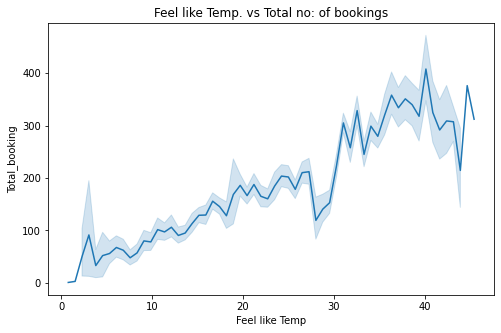

In [ ]:
x = train['atemp']
y = train['Total_booking']
plt.figure(figsize=(8, 5))
sns.lineplot(x = x, y = y)
plt.title('Feel like Temp. vs Total no: of bookings')
plt.xlabel('Feel like Temp')
plt.show()

From the above graph, we can observe that the number of booking has increased as during the summers and there were moderate bookings when the temperature is between 20 - 30.

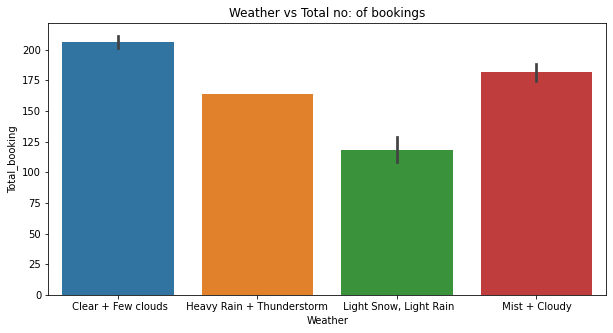

In [ ]:
x = train['weather']
y = train['Total_booking']
plt.figure(figsize=(10, 5))
sns.barplot(x = x, y = y)
plt.title('Weather vs Total no: of bookings')
plt.xlabel('Weather')
plt.show()

People tend to travel more when the weather is clear with few clouds rather than a climate with light snow and light rain as its difficult to travel and also enjoy the weather.

## Correlation Analysis

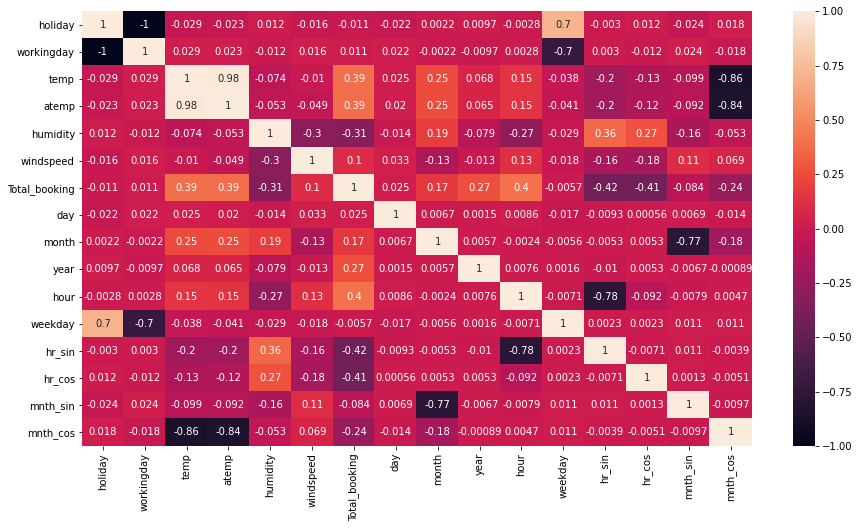

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(), annot=True)
plt.show()

From the above correlation plot, we observe the following the points:

1.   Features such as atemp, temp, humidity show a decent correlation with the target feature.
2.   Temp and atemp are highly correlated, therefore we can discard one of the feature.
3.   Hour and hr_sin, Weekday and working show a high negative correlation, so we can remove one of the feature.

But there are multicolinear features in our dataset. For e.g. workingday and holiday, atemp and temp etc. So we can remove these features from our dataset.


## Train, test and CV data splitup

In [ ]:
X = train.drop(['weekday', 'atemp', 'mnth_sin', 'hr_sin', 'Total_booking', 'holiday', 'weekday', 'day', 'day_name'], axis=1)
y = train['Total_booking']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8526 entries, 0 to 8707
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      8526 non-null   category
 1   workingday  8526 non-null   int64   
 2   weather     8526 non-null   category
 3   temp        8526 non-null   float64 
 4   humidity    8526 non-null   int64   
 5   windspeed   8526 non-null   float64 
 6   month       8526 non-null   int64   
 7   year        8526 non-null   int64   
 8   hour        8526 non-null   int64   
 9   hr_cos      8526 non-null   float64 
 10  mnth_cos    8526 non-null   float64 
dtypes: category(2), float64(4), int64(5)
memory usage: 1003.1 KB


In [ ]:
X['season'] = X['season'].astype('int64')
X['year'] = X['year'].astype('category')
X = pd.get_dummies(X, drop_first=True)

In [ ]:
X.columns

Index(['season', 'workingday', 'temp', 'humidity', 'windspeed', 'month',
       'hour', 'hr_cos', 'mnth_cos', 'weather_ Heavy Rain + Thunderstorm ',
       'weather_ Light Snow, Light Rain', 'weather_ Mist + Cloudy ',
       'year_2012'],
      dtype='object')

Because we have a separate test dataset, in this case we are only considering to split the data into train and cross validation dataset.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_cv = ss.transform(X_cv)

## Training a Linear Regression with default parameters

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_cv)
print(f"RMSE: {np.sqrt(mean_squared_error(y_cv, y_pred))}")

RMSE: 126.03395783235477


## Training a Gradient Boosting Regressor with default parameters

In [ ]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_cv)

In [ ]:
print(f"RMSE: {np.sqrt(mean_squared_error(y_cv, y_pred))}")

RMSE: 61.5307278855512


Comparing Linear regression with Gradient Boosting, we observe that the Gradient Boosting model performance is better than LinearRegression

## Training a Random Forest Regressor with default parameters

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_cv)

In [ ]:
print(f"RMSE: {np.sqrt(mean_squared_error(y_cv, y_pred))}")

RMSE: 46.892108403038854


Random Forest with default parameters performed even better than Gradient Boosting Regressor

## Grid search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
para_grids = {
    "criterion": ["mse", "mae"],
    "n_estimators" : [10, 50, 100],
    "max_features" : ["auto", "log2", "sqrt"],
    }
rfr = RandomForestRegressor(random_state=42)
grid = RandomizedSearchCV(rfr, para_grids, cv=5, verbose=1, n_jobs=1)
grid.fit(X_train, y_train)
print(grid.best_score_, grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.6min finished


0.9350432001452358 {'n_estimators': 100, 'max_features': 'auto', 'criterion': 'mse'}


In [ ]:
forest = grid.best_estimator_
y_pred = forest.predict(X_cv)
print(f"RMSE: {np.sqrt(mean_squared_error(y_cv, y_pred))}")

RMSE: 46.892108403038854


Looks like even after performing GridSearch the RMSE value in the case of RandomForestRegressor remained the same.

## Testing the model with the Final test dataset

In [ ]:
# testing dataset
test = pd.read_csv('/content/drive/MyDrive/edureka_PGP/mid_project_1/test.csv')
test_label = pd.read_csv('/content/drive/MyDrive/edureka_PGP/mid_project_1/test_label.csv', header=None)

In [ ]:
for cat in ['season', 'weather']:
  test[cat] = test[cat].astype('category')

In [ ]:
_ = process_data(test)
test.drop('datetime', axis=1, inplace=True)

In [ ]:
test['hr_sin'] = np.sin(test['hour']*(2.*np.pi/24))
test['hr_cos'] = np.cos(test['hour']*(2.*np.pi/24))
test['mnth_sin'] = np.sin((test['month']-1)*(2.*np.pi/12))
test['mnth_cos'] = np.cos((test['month']-1)*(2.*np.pi/12))

In [ ]:
X_test = test.drop(['weekday', 'atemp', 'mnth_sin', 'hr_sin', 'holiday', 'weekday', 'day', 'day_name'], axis=1)

In [ ]:
X_test['season'] = X_test['season'].map({'Fall':4, 'Summer': 3, 'Winter':2, 'Spring': 1})

In [ ]:
X_test.columns

Index(['season', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
       'month', 'year', 'hour', 'hr_cos', 'mnth_cos'],
      dtype='object')

In [ ]:
X_test['season'] = X_test['season'].astype('int64')
X_test['year'] = X_test['year'].astype('category')
X_test = pd.get_dummies(X_test)

In [ ]:
set(X.columns) - set(X_test.columns)

{'weather_ Heavy Rain + Thunderstorm '}

In [ ]:
X_test['weather_ Heavy Rain + Thunderstorm '] = 0

In [ ]:
X_test = X_test[X.columns]

In [ ]:
X_test = ss.transform(X_test)

In [ ]:
y_pred = forest.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(test_label, y_pred))}")

RMSE: 45.65907785671241


Comparing train and test RMSE, we observe that the model has generalised well with out any overfitting and has performed well on the test data too

## Summary

1.   First we imported the dataset and then checked if there are any outliers in the dataset.
2.   After handling the outliers using IQR, we performed Feature Engineering such as extracting important information from the datetime column in the dataset and converting it in to something useful.
3.   Continuing on, we removed the correlated feature in order to avoid multicolinearity.
4.   Then we build and test with 3 Machine Learning Models:
      1.   Linear Regression - RMSE: 126.03
      2.   Gradient Boosting Regressor - RMSE: 61.53
      3.   Random Forest Regressor - RMSE: 46.89
**Among all the 3 models, we observed that Random Forest Regressor performed well.**
5.    To further improve the performance we looked to better hyperparameters by doing Grid Search but the performance remained **unaffected**.
6.    Finally, we tested the performance of the model using a separate testing dataset and observed that the model was trained well with neither overfitting nor underfitting and the RMSE obtained is: 45.65.

